In [2]:
from scipy.cluster.hierarchy import linkage, fcluster
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from clustering_functions import load_xrd_data, plot_specs, plot_hierarchical_clustering_dendrogram, score_hier_numbers_of_clusters, score_kmeans_numbers_of_clusters, plot_clusters_into_triangles, compute_cluster_mean_std, plot_cluster_mean_spectra, extract_most_typical_sample,highlight_samples_in_cluster_triangle,plot_spectra, compute_cluster_compositional_mean, extract_compos_centroid_sample, create_csmafapbi_compos_str



# LOAD DATA

In [3]:
    
    # Load XRD data with a data loader specified for the dataset under
    # investigation. One sample is dropped already before collecting the csv
    # because its composition log was unclear.
    data_filename = './Data/XRD/xrd_data_scaled.csv'
    data, compositions, theta, sample_df, df_raw_data = load_xrd_data(data_filename = data_filename)
    
    # Set cluster colors for the plots and calculate the xy coordinates of each
    # composition in the tetragonal plots. Works only for tetragonal materials
    # spaces.
    xy, cluster_colors = plot_specs(compositions)
     


Number of samples:  (145, 3)
Samples consist of:
           CsPbI      FAPbI      MAPbI
0     84.000000   0.000000  16.000000
1     39.000000  61.000000   0.000000
2     35.000000  65.000000   0.000000
3     88.333333   0.333333  11.333333
4     78.000000   9.000000  13.000000
..          ...        ...        ...
140   50.000000  50.000000   0.000000
141   75.000000  25.000000   0.000000
142   75.000000   0.000000  25.000000
143   50.000000   0.000000  50.000000
144  100.000000   0.000000   0.000000

[145 rows x 3 columns]
Final shape: (n_samples, n_theta)  (145, 1351)


# HIERARCHICAL CLUSTERING ANALYSIS (BASIC)

Cluster the samples with XRD spectra only (no composition information).


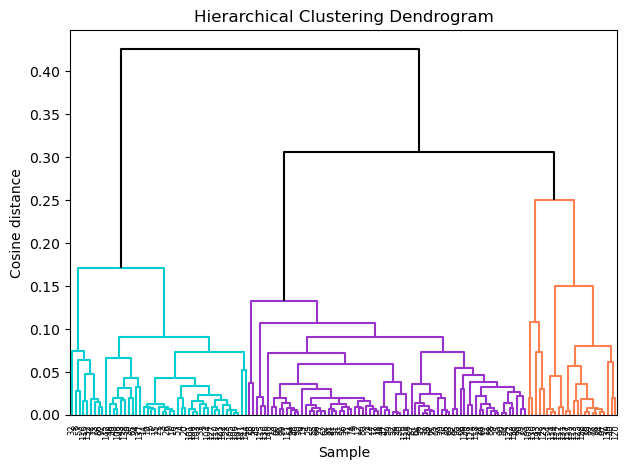

In [4]:
    # Create linkages for the hierarchical clustering dendrogram. Cosine metric
    # is used because the location of the signal (angle theta) is a better base
    # of clustering than the signal amplitude.
    Z = linkage(data, 'average', metric = 'cosine')
    
    plot_hierarchical_clustering_dendrogram(Z, save_fig = False, 
                                                filename = 'hierarchical_clustering_dendrogram',
                                                sample_labels = True)
    


# HIERARCHICAL CLUSTERING ANALYSIS (OUTLIERS)
 
Are there individual samples that would be clustered into their own cluster? Or very small clusters? These may be outliers and should be dropped if they look like that after detailed analysis. No outliers are removed from this XRD dataset.


In [5]:
    cleaned_data = data.copy()
    xy_cleaned = xy.copy()
    sample_df_cleaned = sample_df.copy()
    compositions_cleaned = compositions.copy()
    
    # If you would detect outliers, you could drop them with this function.
    # to_be_dropped = [insert idx here]
    # cleaned_data, xy_cleaned, sample_df_cleaned, compositions_cleaned = drop_data(data, xy, sample_df, compositions, to_be_dropped)
    


# CLUSTERING ANALYSIS (NUMBER OF CLUSTERS)
    
Dendrgram plot suggests there is 3 clusters in the data.
    
Let's test a range of number of clusters to confirm.
Score metrics:
 - Average silhouette score (with cosine metric): value close to 1 means very well defined clusters, -1 failed clustering, 0 overlapping clusters
 - Average Davies - Bouldin score (with Euclidean metric): value 0 is the best possible separation between the clusters, smaller value is better
 - Sample-by-sample silhouette score (with cosine metric): negative score of an individual sample means it has likely been clustered into the wrong cluster, generally, all the clusters should have most of the samples with at least as high silhouette score as the average value (dashed line)


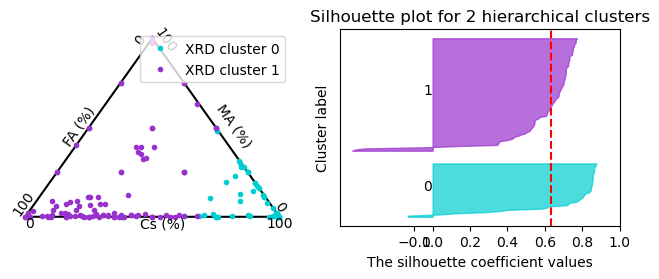

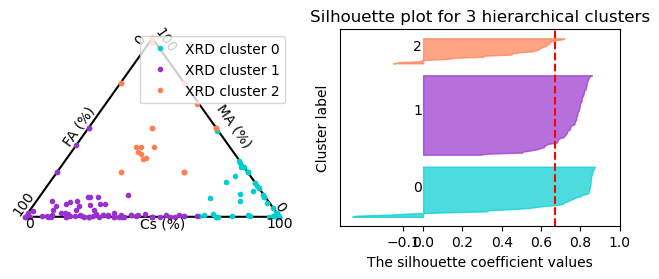

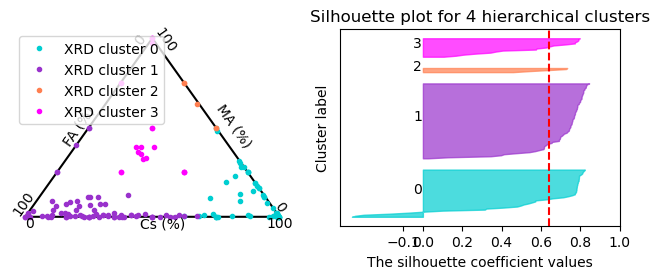

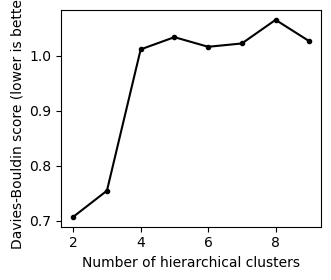

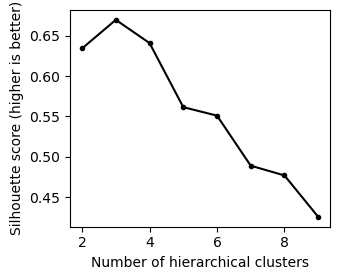

In [6]:
    score_hier_numbers_of_clusters(cleaned_data, xy_cleaned, cluster_colors,
                                       score_metric = 'cosine', 
                                       max_n_clusters = 10,
                                       save_fig = True,
                                       filename = 'xrd_score_hier')
    


The graphs suggest three is indeed the right number of clusters for this dataset. Note that DB score uses Euclidean metric it is not as good score metric for this data as the silhouette score, so where DB and silhouette score suggest different number of clusters, silhouette is more reliable.
    
 For robustness, let's repeat the analysis also for k-means clustering algorithm. Note that the input data for k-means is in this implementation transformed with cosine kernel principal component analysis algorithm. This is because k-means uses Euclidean metric by default and we want to give weight on cosine metric, instead.


/home/armi/anaconda3/envs/clustering-perovskite-temp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/armi/anaconda3/envs/clustering-perovskite-temp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/armi/anaconda3/envs/clustering-perovskite-temp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/armi/anaconda3/envs/clustering-perovskite-temp/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 

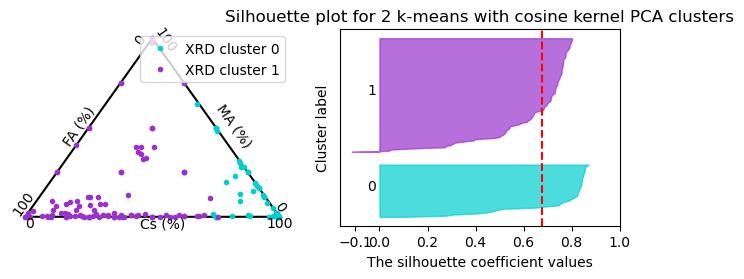

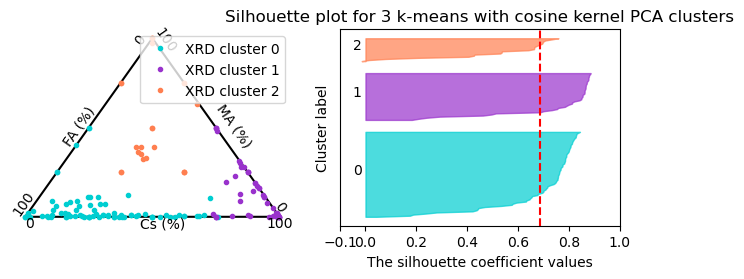

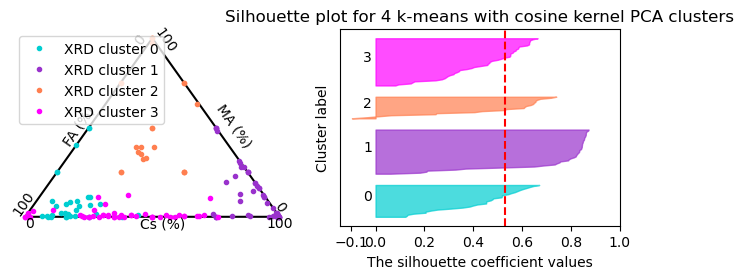

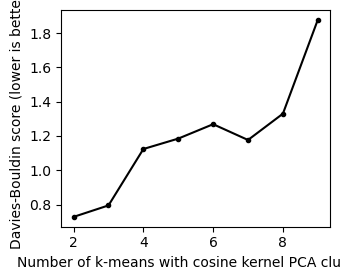

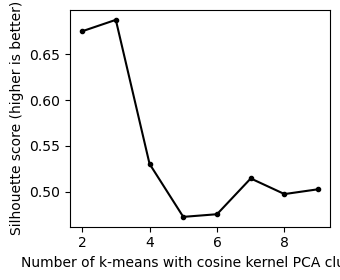

In [7]:
    score_kmeans_numbers_of_clusters(cleaned_data, xy_cleaned, cluster_colors,
                                       score_metric = 'cosine', 
                                       max_n_clusters = 10,
                                       save_fig = True,
                                       filename = 'xrd_score_kmeans')
    


The same result!
    


In [8]:
    # Set the number of clusters for the rest of the analysis to three.
    k = 3

# HIERARCHICAL CLUSTERING ANALYSIS (FINAL CLUSTERING)


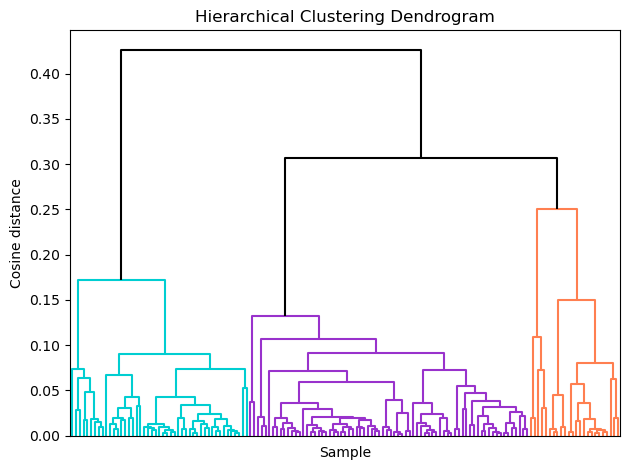

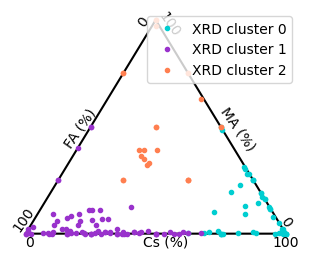

In [9]:
    
    Z = linkage(cleaned_data, 'average', metric = 'cosine')
    plot_hierarchical_clustering_dendrogram(Z, save_fig = True, 
                                                filename = 'xrd_hierarchical_clustering_dendrogram',
                                                sample_labels = False)
    
    # Divide the data into k clusters.
    L = fcluster(Z, k, criterion='maxclust')
    L = L - 1 # Re-index because all the plot functions implemented here assume cluster numbering starts from 0.
    
    plot_clusters_into_triangles(xy_cleaned, n_clusters = k, L=L,
                                 cluster_colors=cluster_colors,
                                 triangle_side_labels = ['Cs (%)', 'FA (%)', 'MA (%)'],
                                 to_single_plot = True)
    
    


# INVESTIGATE MOST TYPICAL XRD SPECTRA WITHIN EACH CLUSTER

Plot arithmetic mean (cluster center) and st.dev of the spectra in each cluster.


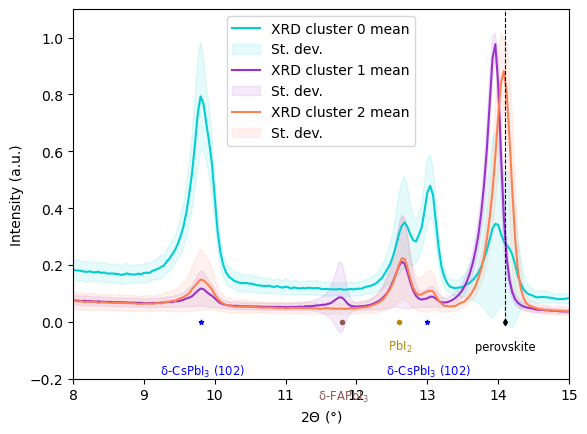

In [10]:
    
    mean, std = compute_cluster_mean_std(cleaned_data, L, k)
    
    plot_cluster_mean_spectra(theta, mean, std, k, cluster_colors,
                             data_type = 'XRD', save_fig = True,
                             filename = 'xrd_cluster_mean')
    


The clusters indeed have differing signature spectra! Let's see how the real samples that resemble the cluster means the most look.

Distance to the cluster mean value (XRD spectrum or degradation curve) i.e. finding the most typical sample in the cluster:
Minimum distance in cluster  0 :  0.6271354099582167 , maximum distance:  7.250757103172734
Index of the minimum distance sample:  4
Details of the min. distance sample:
 CsPbI    0.78
FAPbI    0.09
MAPbI    0.13
Name: 4, dtype: float64 
 Cs$_{0.78}$FA$_{0.09}$MA$_{0.13}$PbI$_3$ 

Distance to the cluster mean value (XRD spectrum or degradation curve) i.e. finding the most typical sample in the cluster:
Minimum distance in cluster  1 :  0.42599736603922467 , maximum distance:  7.250757103172734
Index of the minimum distance sample:  31
Details of the min. distance sample:
 CsPbI    0.223333
FAPbI    0.773333
MAPbI    0.003333
Name: 31, dtype: float64 
 Cs$_{0.22}$FA$_{0.77}$MA$_{0.00}$PbI$_3$ 

Distance to the cluster mean value (XRD spectrum or degradation curve) i.e. finding the most typical sample in the cluster:
Minimum distance in cluster  2 :  0.6510149187382

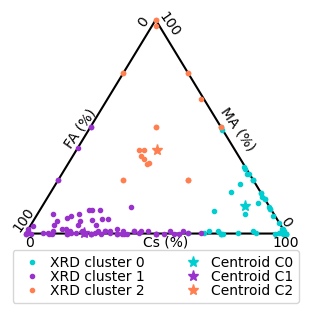

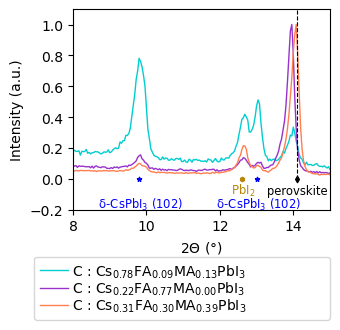

In [11]:
    # Extract the real samples that are the most typical to each cluster.
    cluster_rep, compos_str_cluster_rep, d = extract_most_typical_sample(
        cleaned_data, mean, k, compositions_cleaned, metric = 'euclidean')
    
    # Plot them in the triangle.
    plt.figure()
    plot_clusters_into_triangles(xy_cleaned, k, L, cluster_colors,
                                    show = False)
    highlight_samples_in_cluster_triangle(xy_cleaned, k, cluster_colors,
                                              cluster_rep, cluster_rep_marker = '*',
                                              cluster_rep_label = 'Centroid C',
                                              savefig = True, filename = 'xrd_triangle')
    plt.show()
    
    # Plot their spectra.
    plot_spectra(theta, cleaned_data, cluster_rep, 
                 ['C : ' + i for i in compos_str_cluster_rep],
                 cluster_colors)
    


# INVESTIGATE COMPOSITIONAL CENTROIDS OF EACH CLUSTER

Distance to the cluster compositional center i.e. finding the compositional centroid sample of each cluster:
Minimum distance in cluster  0 :  0.04335311964842345 , maximum distance:  1.4142135623730951
index of minimum distance sample:  4
Details of the min. distance sample:
 CsPbI    0.78
FAPbI    0.09
MAPbI    0.13
Name: 4, dtype: float64 
 Cs$_{0.78}$FA$_{0.09}$MA$_{0.13}$PbI$_3$ 

Distance to the cluster compositional center i.e. finding the compositional centroid sample of each cluster:
Minimum distance in cluster  1 :  0.008126855203914778 , maximum distance:  1.4142135623730951
index of minimum distance sample:  71
Details of the min. distance sample:
 CsPbI    0.25
FAPbI    0.71
MAPbI    0.04
Name: 71, dtype: float64 
 Cs$_{0.25}$FA$_{0.71}$MA$_{0.04}$PbI$_3$ 

Distance to the cluster compositional center i.e. finding the compositional centroid sample of each cluster:
Minimum distance in cluster  2 :  0.03660506188432796 , maximum distance:  1.4142135623730951
index of minimum

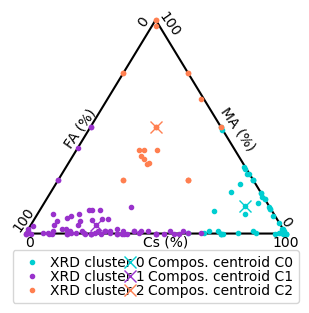

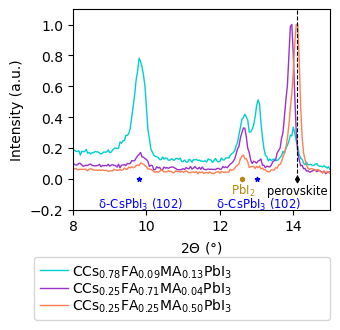

In [12]:
    mean_compos = compute_cluster_compositional_mean(cleaned_data, L, k,
                                           compositions_cleaned)
    
    # Extract the real sample nearest to the center.
    cluster_rep_compos, compos_str_cluster_rep_compos, d_compos = extract_compos_centroid_sample(
        cleaned_data, mean_compos, k, compositions_cleaned, metric = 'euclidean')
    
    # Plot them in the triangle.
    plt.figure()
    plot_clusters_into_triangles(xy_cleaned, k, L, cluster_colors,
                                    show = False)
    highlight_samples_in_cluster_triangle(xy_cleaned, k, cluster_colors,
                                          cluster_rep_compos,
                                          cluster_rep_marker = 'x',
                                          cluster_rep_label = 'Compos. centroid C')
    plt.show()
    
    # Plot their spectra.
    plot_spectra(theta, cleaned_data, cluster_rep_compos, 
                 ['C' + i for i in compos_str_cluster_rep_compos],
                 cluster_colors)
    


# CHECK THAT XRD RAW DATA IS AS IT SHOULD
    
The pipeline this far has considered only normalized XRD data that has also been resampled to constant sampling frequency (otherwise, the clustering would not work).

 Let's fetch the raw data of the cluster centers (most typical samples) to see that everything is as it should be.


Original filenames:
 20190620-JT-7_Cs78FA9MA13_XRD-AB_2-Theta
Original filenames:
 20190711-JT-21_Cs25FA71MA4_XRD-JT_2-Theta
Original filenames:
 20190520-JT-9_1CsPbI1FAPbI2MAPbI_JT-XRD_2-Theta


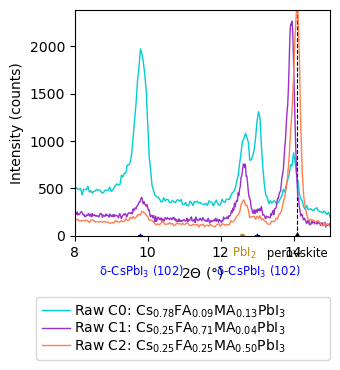

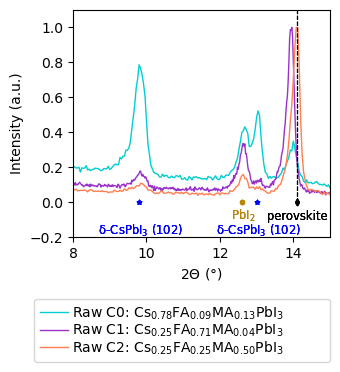

In [13]:
    
    # Load XRD data with a data loader specified for the dataset under
    # investigation.
    r_data_thetas_filename = './Data/XRD/xrd_data_raw_thetas.csv'
    r_data_intensities_filename = './Data/XRD/xrd_data_raw_intensities.csv'
    
    r_data_thetas = pd.read_csv(r_data_thetas_filename, index_col = 0)
    r_data_intensities = pd.read_csv(r_data_intensities_filename, index_col = 0)
    
    
    # Plot raw data without normalization or resampling.
    # Plot their spectra.
    plt.figure()
    for i in range(k):
        
        print('Original filenames:\n', r_data_thetas.iloc[cluster_rep_compos[i],:].name)
        if i == 0:
            show_xrd_expl = True
        else:
            show_xrd_expl = False
        plot_spectra(r_data_thetas.iloc[cluster_rep_compos[i],:],
                 r_data_intensities.iloc[[cluster_rep_compos[i]],:],
                 [0], ['Raw C' + str(i) + ': ' + create_csmafapbi_compos_str(
                     compositions, cluster_rep_compos[i])],
                 [cluster_colors[i]], new_figure = False, data_type = 'XRD raw',
                 show = False, show_xrd_expl = show_xrd_expl)
    plt.show()
    
    # Plot raw data with normalization but without resampling and make sure it
    # looks similar to the plots from clustering (if not similar, there may be
    # an indexing error).
    plt.figure()
    for i in range(k):
        intmax = np.max(r_data_intensities.iloc[cluster_rep_compos[i],:])
        
        plot_spectra(r_data_thetas.iloc[cluster_rep_compos[i],:],
                 r_data_intensities.iloc[[cluster_rep_compos[i]],:] /intmax,
                 [0], ['Raw C' + str(i) + ': ' + create_csmafapbi_compos_str(
                     compositions, cluster_rep_compos[i])],
                 [cluster_colors[i]], new_figure = False, data_type = 'XRD',
                 show = False)
    plt.show()
    


# FINAL PLOT

Finally, plot the originally measured centroid spectra with normalization and without resampling for the paper.

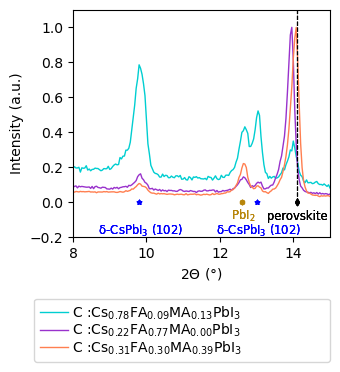

In [14]:
    # Plot raw data with normalization but without resampling.
    plt.figure()
    for i in range(k):
        intmax = np.max(r_data_intensities.iloc[cluster_rep[i],:])
        
        plot_spectra(r_data_thetas.iloc[cluster_rep[i],:],
                 r_data_intensities.iloc[[cluster_rep[i]],:] /intmax,
                 [0], ['C :' + create_csmafapbi_compos_str(
                     compositions, cluster_rep[i])],
                 [cluster_colors[i]], new_figure = False, data_type = 'XRD',
                 show = False)
    
    plt.savefig('xrd_centroid_spectra.png')
    plt.savefig('xrd_centroid_spectra.svg')
    plt.savefig('xrd_centroid_spectra.pdf')
    
    plt.show()


# OPTIONAL: PLOT SUPPLEMENTARY FIGURES

Plot normalized XRD spectra (raw data, not resampled) of the RGB centroid compositions.

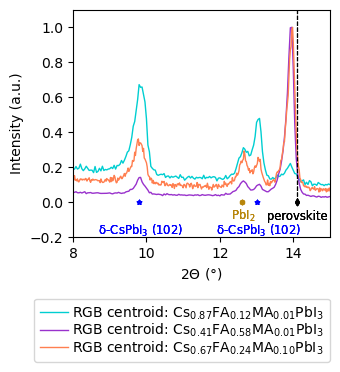

In [15]:
rgb_idx = [23, 29, 72]

plt.figure()
for i in range(len(rgb_idx)):
    intmax = np.max(r_data_intensities.iloc[rgb_idx[i],:])
    
    plot_spectra(r_data_thetas.iloc[rgb_idx[i],:],
             r_data_intensities.iloc[[rgb_idx[i]],:] /intmax,
             [0], ['RGB centroid: ' + create_csmafapbi_compos_str(
                 compositions, rgb_idx[i])],
             [cluster_colors[i]], new_figure = False, data_type = 'XRD',
             show = False)

plt.savefig('xrd_spectra_of_rgb_centroids.png')
plt.savefig('xrd_spectra_of_rgb_centroids.pdf')

plt.show()